In [1]:
import os
import sys
import caffe
from scipy.stats import ortho_group
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)

caffe.set_mode_gpu()

In [2]:
solver = caffe.SGDSolver('solver_v2.prototxt')

In [3]:
a = np.arange(0, 32 + 0.01, 0.01)
d = 0.5*np.sin(2*a) - 0.05 * np.cos( 17*a + 0.8  ) + 0.05 * np.sin( 25 * a + 10 ) - 0.02 * np.cos( 45 * a + 0.3)
d = d / max(np.max(d), -np.min(d))
d = d - np.mean(d)
Nd = len(d)

In [4]:
# This block of code is probably a bad idea

# 0-1 normalization
# d_max = d.max()
# d_min = d.min()
# d = (d - d_min) / (d_max - d_min)

In [5]:
# Random orthogonal initialization
# solver.net.params['lstm1'][2].data[:512] = ortho_group.rvs(512)
# solver.net.params['lstm1'][2].data[512:1024] = ortho_group.rvs(512)
# solver.net.params['lstm1'][2].data[1024:1536] = ortho_group.rvs(512)
# solver.net.params['lstm1'][2].data[1536:] = ortho_group.rvs(512)

In [6]:
preds = np.zeros(len(d))
preds[0] = d[0]
solver.test_nets[0].blobs['data'].data[0,0,0] = d[0]

for i in range(1,len(d)):
    solver.test_nets[0].blobs['clip'].data[0] = i>1
    preds[i] =  solver.test_nets[0].forward()['ip1'][0,0]
    solver.test_nets[0].blobs['data'].data[0,0,0] = preds[i]

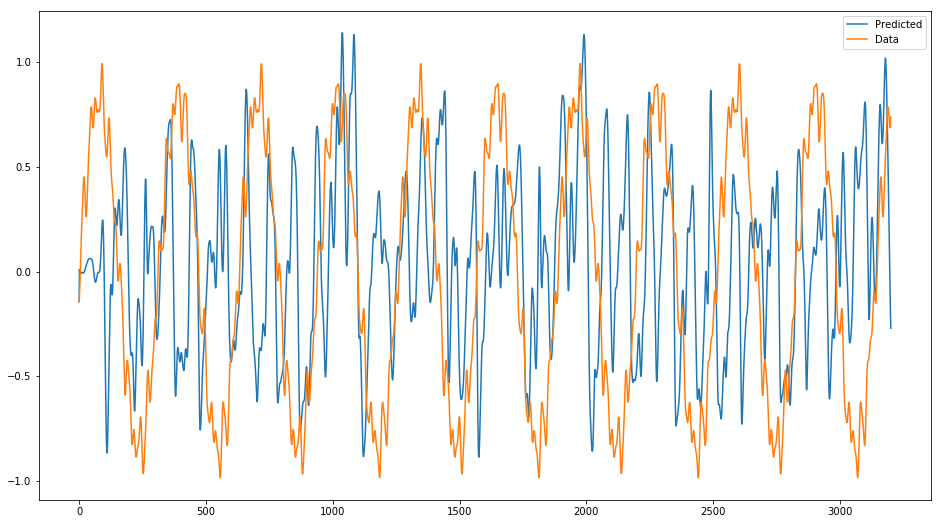

In [8]:
preds_plot, = plt.plot(np.arange(len(d)), preds, label='Predicted')
real_plot, = plt.plot(np.arange(len(d)), d, label='Data')
plt.legend(handles=[preds_plot, real_plot])
plt.show()

In [9]:
# Preparing to train

niter=2000
batch_size = 100
resetter = (Nd - 1) / batch_size

In [10]:
train_loss = np.zeros(niter)
solver.net.blobs['clip'].data[...] = 1
for i in range(niter) :
    seq_idx = i % resetter
    
    solver.net.blobs['clip'].data[0] = seq_idx > 0
    
    start_idx = seq_idx * batch_size
    end_idx = start_idx + batch_size
    solver.net.blobs['data'].data[:, 0, 0] = d[start_idx:end_idx]
    solver.net.blobs['label'].data[:, 0] = d[start_idx+1:end_idx+1]
    
    solver.step(1)
    
    train_loss[i] = solver.net.blobs['loss'].data

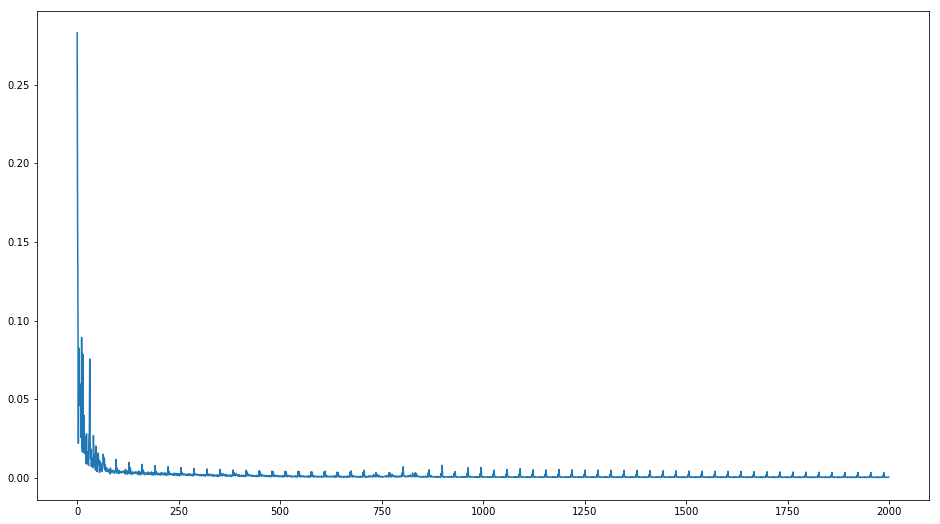

In [11]:
plt.plot(np.arange(niter), train_loss)

In [12]:
preds = np.zeros(len(d))
preds[0] = d[0]
solver.test_nets[0].blobs['data'].data[0,0,0] = d[0]

In [13]:
for i in range(1,len(d)):
    solver.test_nets[0].blobs['clip'].data[0] = i>1
    preds[i] =  solver.test_nets[0].forward()['ip1'][0,0]
    solver.test_nets[0].blobs['data'].data[0,0,0] = preds[i]

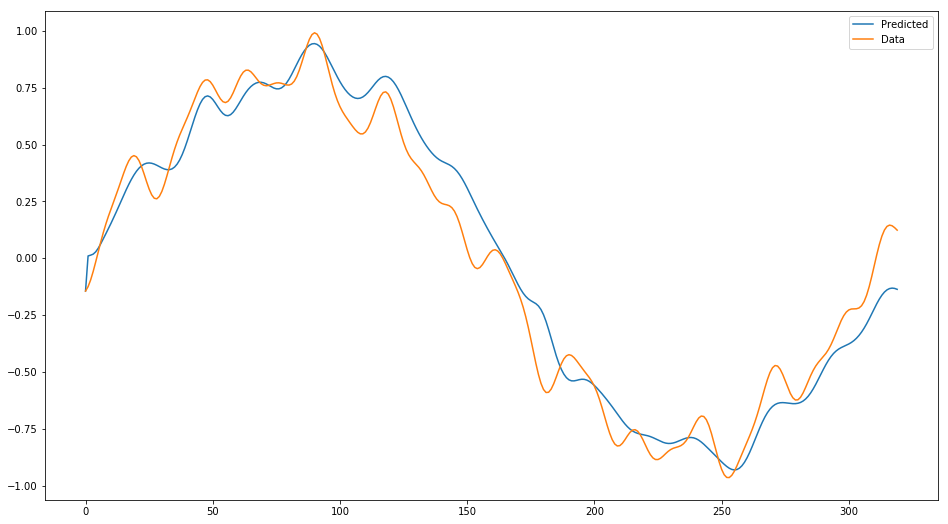

In [14]:
preds_plot, = plt.plot(np.arange(320), preds[:320], label='Predicted')
real_plot, = plt.plot(np.arange(320), d[:320], label='Data')
plt.legend(handles=[preds_plot, real_plot])
plt.show()

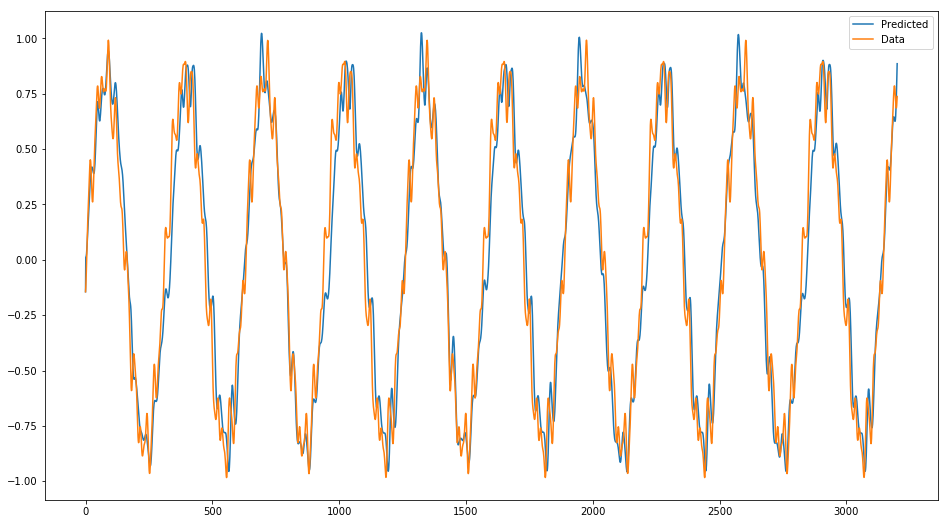

In [15]:
preds_plot, = plt.plot(np.arange(len(d)), preds, label='Predicted')
real_plot, = plt.plot(np.arange(len(d)), d, label='Data')
plt.legend(handles=[preds_plot, real_plot])
plt.show()

In [16]:
caffe.set_mode_cpu()

In [17]:
preds[:100]

array([-0.14395463,  0.01040255,  0.01382634,  0.01835419,  0.02849948,
        0.04451286,  0.06442812,  0.08612919,  0.10834258,  0.1307807 ,
        0.15369731,  0.17737095,  0.20184608,  0.22692855,  0.25227186,
        0.27744001,  0.30193472,  0.32521707,  0.34674555,  0.36602348,
        0.3826403 ,  0.39629519,  0.40680581,  0.4141109 ,  0.41827154,
        0.41947502,  0.41804522,  0.41445374,  0.40932667,  0.40343094,
        0.39763469,  0.39284807,  0.38997674,  0.38989627,  0.39344168,
        0.40137959,  0.4143315 ,  0.43265456,  0.45631474,  0.48480344,
        0.51712739,  0.55187833,  0.58735228,  0.62167704,  0.65292436,
        0.67922151,  0.69890964,  0.710769  ,  0.71428472,  0.70985132,
        0.69882518,  0.68336701,  0.66611779,  0.649791  ,  0.6367892 ,
        0.62891126,  0.62718588,  0.63181162,  0.64220041,  0.65711761,
        0.67491627,  0.69383878,  0.71231484,  0.72916985,  0.74368685,
        0.75552195,  0.76454759,  0.77070451,  0.77394497,  0.77

In [18]:
solver.net.blobs['ip1'].data.shape

(100L, 1L)

In [28]:
solver.test_nets[0].params['lstm1'] == solver.net.params['lstm1']

False

In [30]:
solver.test_nets[0].params['lstm1'][0].data

array([[-0.14880164],
       [-0.02918121],
       [-0.00420656],
       ..., 
       [ 0.15243888],
       [ 0.09728809],
       [-0.0411996 ]], dtype=float32)